# ML for Causal Inference: High-Dimensional Instruments

In [66]:
library(simstudy)
library(glmnet)
library(stats)
library(ggplot2)
library(AER)

## Example: Weak First Stage and Exclusion Restriction Violation

In [67]:
#Simulate Data
set.seed(1)
N <- 1e3 # Number of Observations
# Simulate Data for Example in Intro
weak <- rnorm(n = N)
good <- rnorm(n = N)
correl <- rnorm(n = N) 
C <- 3 * correl + rnorm(n = N)
X <- -.000001 * round(weak) + 2.5 * correl + 2.5 * good + .5 * C + rnorm(n = N)
Y <- 2.0 * X + 1.1 * C + rnorm(n = N)
df <- cbind(Y, X, correl, good, weak)
colnames(df) <- c('Y', 'X', 'correl', 'good', 'weak')
df <- data.frame(df)

In [68]:
# No Instrument, naive regression
fit.none <- lm(Y ~ X, data = df)
summary(fit.none)
X.none <- fit.none$coefficients[2]
ci.none <- confint(fit.none, 'X', level = 0.95)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3707 -1.3519  0.0967  1.4833  7.1721 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.05197    0.07199   0.722    0.471    
X            2.59080    0.01440 179.964   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.276 on 998 degrees of freedom
Multiple R-squared:  0.9701,	Adjusted R-squared:  0.9701 
F-statistic: 3.239e+04 on 1 and 998 DF,  p-value: < 2.2e-16


In [69]:
# Fit using a good instrument (strong first stage and satisfies exclusion restriction)
fit.good <- ivreg(Y ~ X | good, data = df)
summary(fit.good, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.good <- fit.good$coefficients[2]
ci.good <- confint(fit.good, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | good, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-12.17673  -2.46209  -0.01462   2.48840   9.03775 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.05682    0.11246   0.505    0.613    
X            2.04400    0.04075  50.155   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998     435.1  <2e-16 ***
Wu-Hausman         1 997    1575.1  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.56 on Inf degrees of freedom
Multiple R-Squared: 0.9269,	Adjusted R-squared: 0.9268 
Wald test:  2516 on 1 DF,  p-value: < 2.2e-16 


In [70]:
# Fit using a weak instrument (satisfies exclusion restriction)
fit.weak <- ivreg(Y ~ X | weak, data = df)
summary(fit.weak, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.weak <- fit.weak$coefficients[2]
ci.weak <- confint(fit.weak, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | weak, data = df)

Residuals:
       Min         1Q     Median         3Q        Max 
-10.124204  -1.801685   0.004844   1.857427   9.091541 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04916    0.08775   0.560    0.575    
X            2.90671    0.47201   6.158 7.36e-10 ***

Diagnostic tests:
                 df1 df2 statistic p-value
Weak instruments   1 998     1.520   0.218
Wu-Hausman         1 997     0.698   0.404
Sargan             0  NA        NA      NA

Residual standard error: 2.772 on Inf degrees of freedom
Multiple R-Squared: 0.9557,	Adjusted R-squared: 0.9556 
Wald test: 37.92 on 1 DF,  p-value: 7.363e-10 


In [71]:
# Fit using an instrument that doesn't satisfy the exclusion restriction (but with a strong first stage)
fit.correl <- ivreg(Y ~ X | correl, data = df)
summary(fit.correl, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.correl <- fit.correl$coefficients[2]
ci.correl <- confint(fit.correl, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | correl, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-9.51414 -1.64965 -0.05292  1.71357  8.66626 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04978    0.08177   0.609    0.543    
X            2.83672    0.01954 145.181   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998      2201  <2e-16 ***
Wu-Hausman         1 997      1593  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.588 on Inf degrees of freedom
Multiple R-Squared: 0.9614,	Adjusted R-squared: 0.9613 
Wald test: 2.108e+04 on 1 DF,  p-value: < 2.2e-16 


Warning message in data.row.names(row.names, rowsi, i):
"some row.names duplicated: 3,4,5 --> row.names NOT used"Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

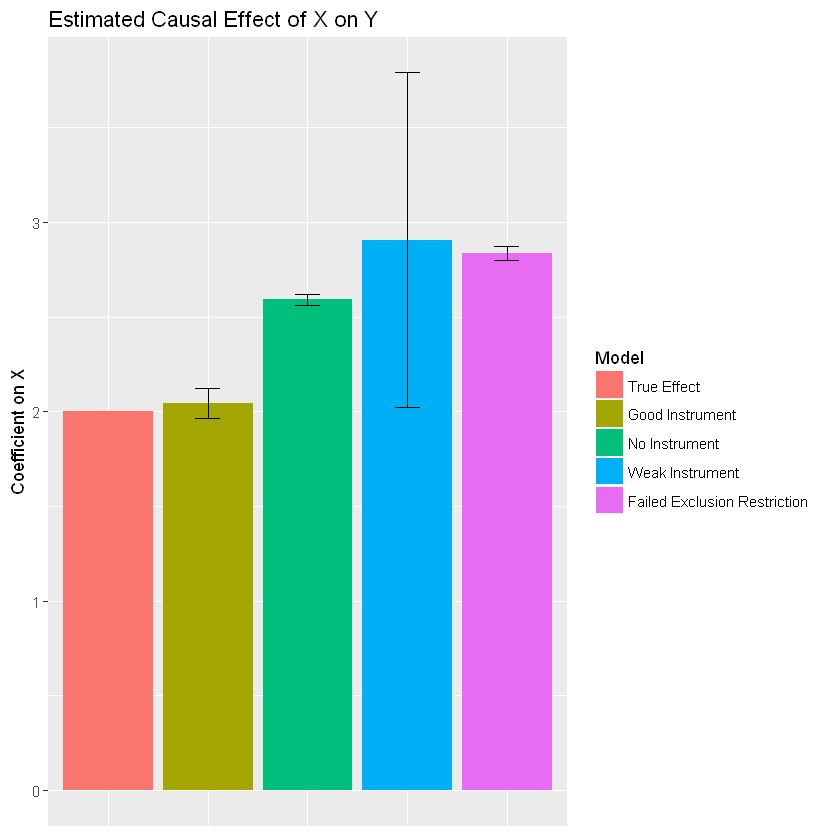

In [72]:
# Vector of T coefficients and confidence intervals
coefs.ab <- c(2.0, X.good, X.none, X.weak, X.correl)
ci.low <- c(NaN, ci.good[1], ci.none[1], ci.weak[1], ci.correl[1])
ci.high <- c(NaN, ci.good[2], ci.none[2], ci.weak[2], ci.correl[2])
dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'Good Instrument', 'No Instrument', 'Weak Instrument', 'Failed Exclusion Restriction'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)
dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

# Create bar graph
dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)
p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))
p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on X") +
    ggtitle("Estimated Causal Effect of X on Y") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

## LASSO for Instrument Selection

In [104]:
rm(list=ls())
invisible(gc()) # Clear workspace
#Simulate Data
set.seed(1)
N <- 1e3 # Number of Observations
p <- N + 30 # Number of instruments (excluding unobservable)
# Generate matrix M of p randomly assigned AB tests
M <- matrix(0, N, p)
M[0:(N/2),] <- 1
M <- apply(t(M), 1, function(d) sample(d, N))
# Create an unobservable C that is a function of a few of our instruments
beta.C <- rnorm(p, mean = 5, sd = 5)
beta.C[21:p] <- 0
C <- M %*% beta.C + rnorm(n = N)
# Create X as a function of weak, good, instruments that don't satisfy the exclusion restriction, and C
beta.X <- rnorm(p, mean = 5, sd = 5)
beta.X[21:40] <- rnorm(20, mean = 0, sd = .0001)
X <- M %*% beta.X - 10.0 * C + rnorm(n = N)
# Create Y as a function of C and X
Y <- 2.0 * X - 15.0 * C + rnorm(n = N)
# Create data frames with and without variables that don't satisfy the exclusion restriction
df.allM <- data.frame('Y' = Y, 'X' = X, 'M' = M)
df.excl <- data.frame('Y' = Y, 'X' = X, 'M' = M[, 21:p])

## LASSO X on M

In [105]:
fit.noinst <- lm(Y ~ X, data = df.allM)
summary(fit.noinst)


Call:
lm(formula = Y ~ X, data = df.allM)

Residuals:
    Min      1Q  Median      3Q     Max 
-480.19 -101.54    7.09   96.43  457.38 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.851e+03  4.408e+01  -64.68   <2e-16 ***
X            2.982e+00  2.154e-02  138.47   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 141.8 on 998 degrees of freedom
Multiple R-squared:  0.9505,	Adjusted R-squared:  0.9505 
F-statistic: 1.917e+04 on 1 and 998 DF,  p-value: < 2.2e-16
